# **LightGBM**

In dit notebook wordt een LightGBM model getrained om te kijken of er een omslagpunt te voorspellen is. 

**Waarom `LightGBM` ?**
- Efficient met grote datasets
- Goede prestaties bij class imbalance
- Snelle training door leafwise tree growth


## Imports 

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import sys
from pathlib import Path
current_dir = Path.cwd()
project_dir = current_dir.parent.parent
sys.path.append(str(project_dir))
from pipeline import prepare_data, undersample, markeer_omslagpunten

## Data inladen

In [2]:
file_path = r"../../data/export_location_modeling/export_location_modeling.csv"

df_raw = pd.read_csv(file_path)

# Pipeline Uitvoeren

De `prepare_data()` functie uit onze pipeline voert de volgende stappen uit:
- Cleaning en filtering van ruwe data
- Feature engineering (smoothing, tijd-features)
- Labeling van omslagpunten

In [3]:
df = prepare_data(df_raw)
df = markeer_omslagpunten(df)

Totaal gedetecteerde files: 698
-----------------------------------------------------
Detected files (unique file_id): 698
Marked omslagpunten:             698
-----------------------------------------------------


# Features en target

Voor dit model gebruiken we drie features:
- `gem_intensiteit_smooth` 
- `tijd` 
- `day_of_week` 

Met de volgende target: `file_omslag_flag`


In [4]:
# Features selecteren
features = ['gem_intensiteit_smooth', 'tijd', 'day_of_week']
target = 'file_omslag_flag'

X = df[features]
y = df[target]

## Target Verdeling
Voordat we gaan modelleren, bekijken we eerst de verdeling van de target variabele.

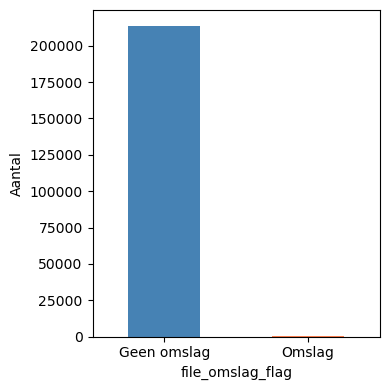

In [5]:
plt.figure(figsize=(4, 4))
df[target].value_counts().plot(kind='bar', color=['steelblue', 'coral'])
plt.ylabel('Aantal')
plt.xticks(ticks=[0, 1], labels=['Geen omslag', 'Omslag'], rotation=0)
plt.tight_layout()
plt.show()

De target variabele is sterk ongebalanceerd: slechts 698 van de 214.626 meetpunten (0.33%) zijn omslagpunten. Dit vereist undersampling bij het trainen van het model.

# Train test split uitvoeren op de volledige data

We gebruiken een 80/20 split met stratificatie om de class verdeling te behouden:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Undersamplen

Onze dataset heeft een zeer scheve verdeling: 0.3% van de datapunten zijn omslagpunten. Dit maakt classificatie uitdagend.
We passen undersampling toe op de trainingsdata via onze pipeline. Dit betekent dat we willekeurig negatieve samples verwijderen tot een ratio van 3:1 (negatief:positief).

In [7]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df_balanced = undersample(train_df, minority_class=1, ratio=3, random=42)

X_train_balanced = train_df_balanced[features]
y_train_balanced = train_df_balanced[target]

In [8]:
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=-1
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

cv_results = cross_validate(
    model, 
    X_train_balanced, 
    y_train_balanced, 
    cv=cv, 
    scoring=scoring
)

# Resultaten printen
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {scores.mean():.4f} (+/- {scores.std():.4f})")

Accuracy: 0.8665 (+/- 0.0107)
Precision: 0.7354 (+/- 0.0168)
Recall: 0.7246 (+/- 0.0245)
F1: 0.7298 (+/- 0.0189)


Het model behaalt een goede balans tussen precision (74%) en recall (73%) op de undersampled trainingsdata. De lage standaarddeviaties tonen aan dat het model stabiel presteert over de 5 folds.

## Hyperparameter Tuning

We optimaliseren de hyperparameters met GridSearchCV. We scoren op recall omdat het detecteren van omslagpunten belangrijker is dan het vermijden van false positives.

In [9]:
# GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63]
}

grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, verbose=-1),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print(f"Beste parameters: {grid_search.best_params_}")
print(f"Beste F1 score (CV): {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Beste parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'num_leaves': 63}
Beste F1 score (CV): 0.7723


De beste parameters geven een recall van 77% op de cross-validation. Het model kiest voor een hogere `max_depth` (7) en meer `num_leaves` (63).

# Evaluatie op de test set

              precision    recall  f1-score   support

           0       1.00      0.91      0.95     42786
           1       0.03      0.77      0.05       140

    accuracy                           0.91     42926
   macro avg       0.51      0.84      0.50     42926
weighted avg       1.00      0.91      0.95     42926



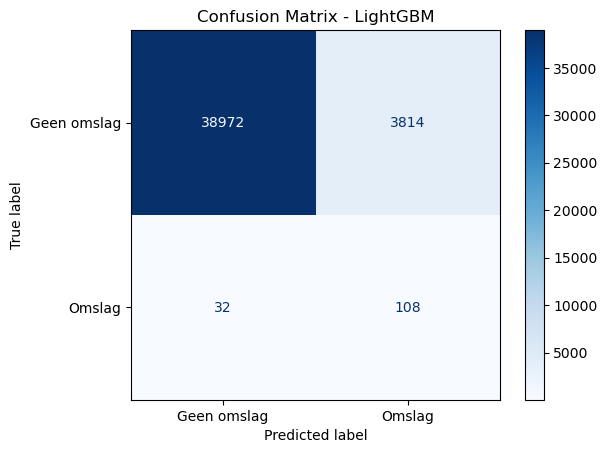

In [10]:
best_model = grid_search.best_estimator_

# Evalueren op test set
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Geen omslag', 'Omslag'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.show()

Het model behoudt een hoge recall (77%) op de test set: 108 van de 140 omslagpunten worden gedetecteerd. De lage precision (3%) komt door de vele false positives (3814), wat onvermijdelijk is bij deze extreme class imbalance.

## Conclusie

Het model herkent de meeste omslagpunten (77% recall) maar de lage precision (3%) maakt het in deze vorm niet praktisch inzetbaar. Meer features of een andere aanpak is nodig.